In [265]:
%reload_ext autoreload
%autoreload 2

# Analysis 101

To do:
- colour-code points by the distance from the mean pH to contextualise the magnitude of experimental change in pH
- amalgamate any studies with n=1 since need sd for hedges
- deal with temperature-only studies (not all studies have carbonate chemistry)
- plot 3d plot of temperature, ph,


In [266]:
### import
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# clustering
from sklearn.cluster import KMeans

# custom
import analysis, utils, plotting

In [ ]:
climatology_data_fp = "data/climatology/site_locations_with_MMM_and_pH.csv"

climatology_df = pd.read_csv(climatology_data_fp)
# drop unnecessary columns
climatology_df = climatology_df.drop(columns=['data_ID', 'Unnamed: 0']).set_index('doi')
# TODO: format geometry column(s) into lat and lon
climatology_df.head()

## Multi-variable study

In [ ]:
# generate carbonate chemistry data
meta_fp = "data/Orlando_data.xlsx"
carb_df = utils.populate_carbonate_chemistry(meta_fp, 'all_data')
print(carb_df.shape)

# select only my data for now (not yet uniform)
carb_df = carb_df[carb_df['extractor'] == 'Orlando']

# prepare for future alignment with climatology (first uniquify dois in the same way)
unique_pairs = carb_df.drop_duplicates(subset=['doi', 'location'])[['doi', 'location']]
unique_pairs.doi = utils.uniquify_repeated_values(carb_df.drop_duplicates(subset=['doi', 'location']).doi)
# unique_pairs
# assign these unique dois to the correct pairs in carb_df
# Create a dictionary mapping from original (doi, location) pairs to uniquified dois
doi_location_map = dict(zip(zip(carb_df.drop_duplicates(subset=['doi', 'location'])['doi'], 
                               carb_df.drop_duplicates(subset=['doi', 'location'])['location']), 
                         unique_pairs['doi']))

# Create a copy of the original DOIs
carb_df['original_doi'] = carb_df['doi']

# Apply the mapping to update DOIs
carb_df['doi'] = [doi_location_map.get((doi, loc), doi) for doi, loc in zip(carb_df['doi'], carb_df['location'])]


print(carb_df.shape)

### Demonstration of automatic treatment recognition

In [ ]:
def group_irradiance(df, irr_col='irr', rtol=0.10):
    """
    Assigns an 'irr_group' to values that are within a relative tolerance.
    
    Args:
        df (pd.DataFrame): Input dataframe with an 'irr' column.
        irr_col (str): Column name for irradiance values.
        rtol (float): Relative tolerance (e.g., 0.10 for 10%).
        
    Returns:
        pd.DataFrame: Dataframe with new 'irr_group' column.
    """
    df = df.copy().sort_values(by=irr_col)  # copy to prevent modification of og, sort for efficiency
    irr_groups = np.zeros(len(df))  # initialize array for group assignments
    group_id = 0
    prev_irr = None

    for i, irr in enumerate(df[irr_col]):
        if np.isnan(irr):   # handling grouping where irr is NaN
            irr_groups[i] = np.nan
        elif prev_irr is None or np.abs(irr - prev_irr) / prev_irr > rtol:   # if first value or outside tolerance
            group_id += 1
        irr_groups[i] = group_id
        prev_irr = irr

    df['irr_group'] = irr_groups
    return df


# test_doi = carb_df.doi.unique()[7]
test_doi = "10.1111/jpy.13290"
print(test_doi)
test_df = carb_df[carb_df.doi == test_doi].copy()

treatment_vars = ['t_in', 'phtot']
# columns of interest
cols = ['species_types', 'treatment_group', 'calcification'] + treatment_vars


def assign_treatment_groups(df: pd.DataFrame, t_atol: float=0.1, pH_atol: float=0.1, irr_rtol: float=0.1) -> pd.DataFrame:
    # 1 – group by irradiance
    df = df.copy()
    
    treatment_dfs = []
    for study_doi, study_df in df.groupby('doi'):
        study_df = group_irradiance(study_df, rtol=irr_rtol)

        # 2 – process treatments within species and irradiance groups
        for (irr_group, species), species_df in study_df.groupby(['irr_group', 'species_types']):
            # handle NaN irradiance separately
            irr_label = 'nan' if np.isnan(irr_group) else f"group_{int(irr_group)}"
            # identify controls (min T, max pH) # TODO: optional replace with closest to climatology
            control_T = species_df.loc[species_df['t_in'].idxmin(), 't_in'] if not species_df['t_in'].isna().all() else None
            control_pH = species_df.loc[species_df['phtot'].idxmax(), 'phtot'] if not species_df['phtot'].isna().all() else None

            def classify_treatment(row):
                close_T = np.isclose(row['t_in'], control_T, atol=t_atol) if control_T is not None else False
                close_pH = np.isclose(row['phtot'], control_pH, atol=pH_atol) if control_pH is not None else False

                if close_T and close_pH:
                    return 'cT' + 'cP'
                elif close_T:
                    return 'cT' + 'tP'
                elif close_pH:
                    return 'tT' + 'cP'
                elif not (close_T or close_pH):
                    return 'tT' + 'tP'
                else:
                    return 'uncertain'

            species_df['treatment_group'] = species_df.apply(classify_treatment, axis=1)
            
            treatment_dfs.append(species_df)

    return pd.concat(treatment_dfs, ignore_index=True)

carb_df_tgs = assign_treatment_groups(carb_df)
carb_df_tgs


In [ ]:
def group_irradiance(df, irr_col='irr', atol=30):
    """
    Assigns an 'irr_group' to values that are within a relative tolerance.
    
    Args:
        df (pd.DataFrame): Input dataframe with an 'irr' column.
        irr_col (str): Column name for irradiance values.
        rtol (float): Relative tolerance (e.g., 0.10 for 10%).
        
    Returns:
        pd.DataFrame: Dataframe with new 'irr_group' column.
    """
    df = df.copy().sort_values(by=irr_col)  # copy to prevent modification of original, sort for efficiency
    irr_groups = np.zeros(len(df))  # initialize array for group assignments
    group_id = 0
    prev_irr = None

    for i, irr in enumerate(df[irr_col]):
        if np.isnan(irr):   # handling grouping where irr is NaN
            irr_groups[i] = -1  # Use a distinct value for NaN irradiance
        elif prev_irr is None:
            # First non-NaN value starts group 1
            group_id = 1
            irr_groups[i] = group_id
        elif np.abs(irr - prev_irr) > atol:
            # Outside tolerance, create new group
            group_id += 1
            irr_groups[i] = group_id
        else:
            # Within tolerance, use current group
            irr_groups[i] = group_id
            
        # Update prev_irr only for non-NaN values
        if not np.isnan(irr):
            prev_irr = irr

    # Add irr_group column to dataframe
    df['irr_group'] = irr_groups
    return df


def assign_treatment_groups(df: pd.DataFrame, t_atol: float=0.1, pH_atol: float=0.1, irr_rtol: float=0.1) -> pd.DataFrame:
    """
    Assign treatment groups to each row based on temperature and pH values.
    
    Args:
        df (pd.DataFrame): Input dataframe with columns 'doi', 't_in', 'phtot', etc.
        t_atol (float): Absolute tolerance for temperature comparison.
        pH_atol (float): Absolute tolerance for pH comparison.
        irr_rtol (float): Relative tolerance for irradiance grouping.
        
    Returns:
        pd.DataFrame: Original dataframe with added 'treatment_group' column.
    """
    # Create a copy of the original dataframe to preserve all rows
    result_df = df.copy()
    
    # Initialize treatment_group column with NaN
    result_df['treatment_group'] = pd.Series(dtype='object')
    
    # Process each study separately
    for study_doi, study_df in df.groupby('doi'):
        # Group by irradiance within this study
        study_with_irr_groups = group_irradiance(study_df, atol=irr_rtol)
        
        # Process each (irradiance group, species) combination separately
        for (irr_group, species), group_df in study_with_irr_groups.groupby(['irr_group', 'species_types']):
            # Find control values (min T, max pH)
            control_T = group_df['t_in'].min() if not group_df['t_in'].isna().all() else None
            control_pH = group_df['phtot'].max() if not group_df['phtot'].isna().all() else None
            
            # Apply classification to each row in this group
            for idx in group_df.index:
                row = group_df.loc[idx]
                
                # Determine if values are close to control values
                close_T = np.isclose(row['t_in'], control_T, atol=t_atol) if control_T is not None and not np.isnan(row['t_in']) else False
                close_pH = np.isclose(row['phtot'], control_pH, atol=pH_atol) if control_pH is not None and not np.isnan(row['phtot']) else False
                
                        # TODO: when treatment_group ns are 1, need to cluster by extremity of treatment group... Should be done earlier

                # Classify the treatment
                if close_T and close_pH:
                    treatment = 'cTcP'
                elif close_T:
                    treatment = 'cTtP'
                elif close_pH:
                    treatment = 'tTcP'
                elif not (close_T or close_pH):
                    treatment = 'tTtP'
                else:
                    treatment = 'uncertain'
                
                # Update the treatment_group in the result dataframe
                result_df.loc[idx, 'treatment_group'] = treatment
                
                # Also store irr_group from the grouped dataframe
                result_df.loc[idx, 'irr_group'] = irr_group
    
    return result_df

# carb_df_tgs = assign_treatment_groups(carb_df, t_atol=0.4)
carb_df_tgs = analysis.assign_treatment_groups_multilevel(carb_df)
some_cols = cols + ['calcification_sd', 'irr', 'irr_group', 'treatment_group', 'treatment_level_t', 'treatment_level_ph', 'doi', 'treatment']
carb_df_tgs[some_cols]

In [ ]:
# results_df = calc_hedges_g(carb_df_tgs[carb_df_tgs.doi=="10.1016/j.jembe.2016.10.002"])   # testing
# results_df = analysis.hedges_g_for_df(carb_df_tgs[carb_df_tgs.doi=="10.1016/j.jembe.2016.10.002"])   # testing
results_df = analysis.hedges_g_for_df(carb_df_tgs)
all_cols = cols + ['calcification_sd', 'irr', 'irr_group', 'hedges_g', 'hedges_g_l', 'hedges_g_u', 'delta_t', 'delta_pH', 'doi'] + ['treatment_group', 'n', 'control_calcification']
results_df[all_cols]

In [ ]:
results_df.columns

In [ ]:
results_df[['doi', 'irr', 'species_types', 'phtot', 't_in', 'n', 'calcification', 'calcification_sd', 'calcification_se',
       'treatment', 'treatment_val', 'treatment_group', 'treatment_level_t', 'treatment_level_ph', 'irr_group', 'delta_t', 'delta_pH',
       'hedges_g', 'control_calcification', 'treatment_calcification', 'co3', 'dic', 'do', 'hco3', 'ipar', 'pco2', 'phnbs', 's_in',  'ta', 'extractor', 'include', ]].to_csv('data/quick_test_results.csv', index=False)

In [ ]:
results_df.treatment.value_counts()

In [ ]:
### merge results with climatology data
matched_df = results_df.set_index('doi').merge(climatology_df, left_index=True, right_index=True)   # TODO: drops ~100 rows for some reason

# define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['treatment']]]
    if row['treatment'] in clim_var_map else np.nan,
    axis=1
)
# assign which variable to use for delta calculation
matched_df['delta_var'] = matched_df.apply(
    lambda row: row['delta_t'] if row['treatment'] == 't_in' else row['delta_pH'],
    axis=1)

In [ ]:
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

plot_results = matched_df
plot_results = plot_results.dropna(subset=['delta_t', 'delta_pH', 'hedges_g'])

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])   # remove NaNs and infinities
    delta_var = subset_df['delta_t'] if var == 't_in' else subset_df['delta_pH']
    
    # plot regression line
    summary_stats = plotting.simple_regplot(delta_var, subset_df['hedges_g'], ax=ax, line_kws={"color": "r"}, ci_kws={"color": "red"})
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]

    # plot error bars with delta climatology colours
    for i, (x, y, yerr, color) in enumerate(zip(delta_var, subset_df['hedges_g'], 
                                            (subset_df['hedges_g'] - subset_df['hedges_g_l']).values, 
                                            colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='none', ecolor=color, alpha=0.7, lw=1)
    
    scatter = ax.scatter(delta_var, subset_df['hedges_g'],
                         c=subset_df['clim_delta'], cmap=cmap, norm=norm,
                         alpha=0.8, lw=0.1, edgecolor='black')
                         
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, pad=0.11, orientation = 'horizontal')
    cbar.set_label(f"Δ{var_name} from local climatology")

    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0), 1, 1, fc="red", edgecolor='none', alpha=0.5)
    ax.plot([], [], alpha=0, label=f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from scipy import stats
import plotly.express as px
plot_results = matched_df
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, 
                    subplot_titles=("Effect of pH (Total) on calcification rate", 
                                   "Effect of Temperature (°C) on calcification rate"))

variables = ['phtot', 't_in']
var_names = ['pH (Total)', 'Temperature (°C)']
delta_vars = ['delta_pH', 'delta_t']

# process each subplot
for i, (var, var_name, delta_var) in enumerate(zip(variables, var_names, delta_vars)):
    col = i+1  # plotly uses 1-indexed columns for some reason
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    # data cleaning (NaNs and infinities)
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])
    # relevant variable    
    x_values = subset_df[delta_var]
    y_values = subset_df['hedges_g']
    y_error = subset_df['hedges_g'] - subset_df['hedges_g_l']
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]
    
    # regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
    r_squared = r_value**2
    adjusted_r_squared = 1 - ((1 - r_squared) * (len(x_values) - 1) / (len(x_values) - 2))
    x_reg = np.linspace(min(x_values), max(x_values), 100)
    y_reg = slope * x_reg + intercept

    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg,
            mode='lines',
            line=dict(color='red'),
            name=f'y = {slope:.2f}x + {intercept:.2f}'
        ),
        row=1, col=col
    )
    # add approximated confidence interval
    ci = 1.96 * std_err  # 95% CI
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg + ci,
            mode='lines',
            line=dict(width=0),
            showlegend=False
        ),
        row=1, col=col
    )    
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg - ci,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(255, 0, 0, 0.2)',
            name='95% CI'
        ),
        row=1, col=col
    )
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # add scatter points with error bars and hover text
    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=y_values,
            mode='markers',
            marker=dict(
                # color=colors[0:10],  # Use the colors list generated from climatology delta
                # colors= cmap,
                size=10, 
                line=dict(width=1, color='black'), 
                opacity=0.5
            ),
            # color_continuous_scale='coolwarm',
            error_y=dict(
                type='data',
                array=y_error,
                visible=True,
                color='blue',
                thickness=1,
                width=5
            ),
            name='Data points',
            hovertemplate=
            f'Δ{var_name}: %{{x}}<br>' +
            'Hedges\' g: %{y}<br>' +
            'Treatment Calcification: %{customdata[0]:.4f}<br>' +
            'Control Calcification: %{customdata[1]:.4f}<br>' +
            'DOI: %{text}<extra></extra>',
            text=subset_df.index,
            customdata=subset_df[['treatment_calcification', 'control_calcification']]
        ),
        row=1, col=col
    )
    # add horizontal line at y=0 (Hedges g = 0)
    fig.add_trace(
        go.Scatter(
            x=[min(x_values), max(x_values)],
            y=[0, 0],
            mode='lines',
            line=dict(color='black', width=1, dash='dash'),
            name="Hedges' g = 0"
        ),
        row=1, col=col
    )


fig.update_layout(
    width=1200,
    height=600,
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-.2,
        xanchor="right",
        x=1
    )
)

# Update x and y axis labels
for i in range(2):
    fig.update_xaxes(title_text=f"Δ{var_names[i]}", row=1, col=i+1, gridcolor='lightgrey')

fig.update_yaxes(title_text="Hedges' g", row=1, col=1, gridcolor='lightgrey')

# Show the figure
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from scipy import stats

plot_results = results_df
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, 
                    subplot_titles=("Effect of pH (Total) on calcification rate", 
                                   "Effect of Temperature (°C) on calcification rate"))

variables = ['phtot', 't_in']
var_names = ['pH (Total)', 'Temperature (°C)']
delta_vars = ['delta_pH', 'delta_t']

# process each subplot
for i, (var, var_name, delta_var) in enumerate(zip(variables, var_names, delta_vars)):
    col = i+1  # plotly uses 1-indexed columns for some reason
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    # data cleaning (NaNs and infinities) 
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])
    # relevant variable    
    x_values = subset_df[delta_var]
    y_values = subset_df['hedges_g']
    y_error = subset_df['hedges_g'] - subset_df['hedges_g_l']
    
    # regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
    r_squared = r_value**2
    adjusted_r_squared = 1 - ((1 - r_squared) * (len(x_values) - 1) / (len(x_values) - 2))
    x_reg = np.linspace(min(x_values), max(x_values), 100)
    y_reg = slope * x_reg + intercept

    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg,
            mode='lines',
            line=dict(color='red'),
            name=f'y = {slope:.2f}x + {intercept:.2f}'
        ),
        row=1, col=col
    )
    # add approximated confidence interval
    ci = 1.96 * std_err  # 95% CI
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg + ci,
            mode='lines',
            line=dict(width=0),
            showlegend=False
        ),
        row=1, col=col
    )    
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg - ci,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(255, 0, 0, 0.2)',
            name='95% CI'
        ),
        row=1, col=col
    )
    
    # add scatter points with error bars and hover text
    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=y_values,
            mode='markers',
            marker=dict(color='blue', size=10, line=dict(width=1, color='black'), opacity=0.5),
            error_y=dict(
                type='data',
                array=y_error,
                visible=True,
                color='blue',
                thickness=1,
                width=5
            ),
            name='Data points',
            hovertemplate=
            f'Δ{var_name}: %{{x}}<br>' +
            'Hedges\' g: %{y}<br>' +
            'Treatment Calcification: %{customdata[0]:.4f}<br>' +
            'Control Calcification: %{customdata[1]:.4f}<br>' +
            'DOI: %{text}<extra></extra>',
            text=subset_df['doi'],
            customdata=subset_df[['treatment_calcification', 'control_calcification']]
        ),
        row=1, col=col
    )
    
    # add horizontal line at y=0 (Hedges g = 0)
    fig.add_trace(
        go.Scatter(
            x=[min(x_values), max(x_values)],
            y=[0, 0],
            mode='lines',
            line=dict(color='black', width=1, dash='dash'),
            name="Hedges' g = 0"
        ),
        row=1, col=col
    )


fig.update_layout(
    width=1200,
    height=600,
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-.2,
        xanchor="right",
        x=1
    )
)

# Update x and y axis labels
for i in range(2):
    fig.update_xaxes(title_text=f"Δ{var_names[i]}", row=1, col=i+1, gridcolor='lightgrey')

fig.update_yaxes(title_text="Hedges' g", row=1, col=1, gridcolor='lightgrey')

# Show the figure
fig.show()

In [ ]:
results

# Main analysis


### Basic plotting of result

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

# plot_results = results_df[results_df.multi_var==1]
plot_results = results_df

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    # subset = results_df[results_df.multi_var==1][results_df[results_df.multi_var==1]['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    # plot regression line
    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # # Plot error bars **matching scatter point colors**
    # for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
    #                                             (subset['hedges_g'] - subset['hg_ci_l']).values, 
    #                                             colors)):
    #     ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c="blue",
                         alpha=0.8, lw=0.1, edgecolor='black')

    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [ ]:
# Match by DOI the Hedges' g results with the climatology data
# matched_df = results_df.join(climatology_df, how="left", rsuffix="_clim")
matched_df = results_df.merge(climatology_df, left_index=True, right_index=True)

# Define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# Calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['variable']]]
    if row['variable'] in clim_var_map else np.nan,
    axis=1
)

In [ ]:
# set(climatology_df.index) - set(carb_df['doi'].unique())
set(climatology_df.index) - set(results_df.index)


In [ ]:
print(len(matched_df))
print(matched_df.clim_delta.isna().sum())

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    cmap = cm.coolwarm
    norm = mcolors.Normalize(vmin=subset['clim_delta'].min(), vmax=subset['clim_delta'].max())
    colors = [cmap(norm(val)) for val in subset['clim_delta']]

    # Plot error bars **matching scatter point colors**
    for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
                                                (subset['hedges_g'] - subset['hg_ci_l']).values, 
                                                colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c=subset['clim_delta'], cmap=cmap, norm=norm, 
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

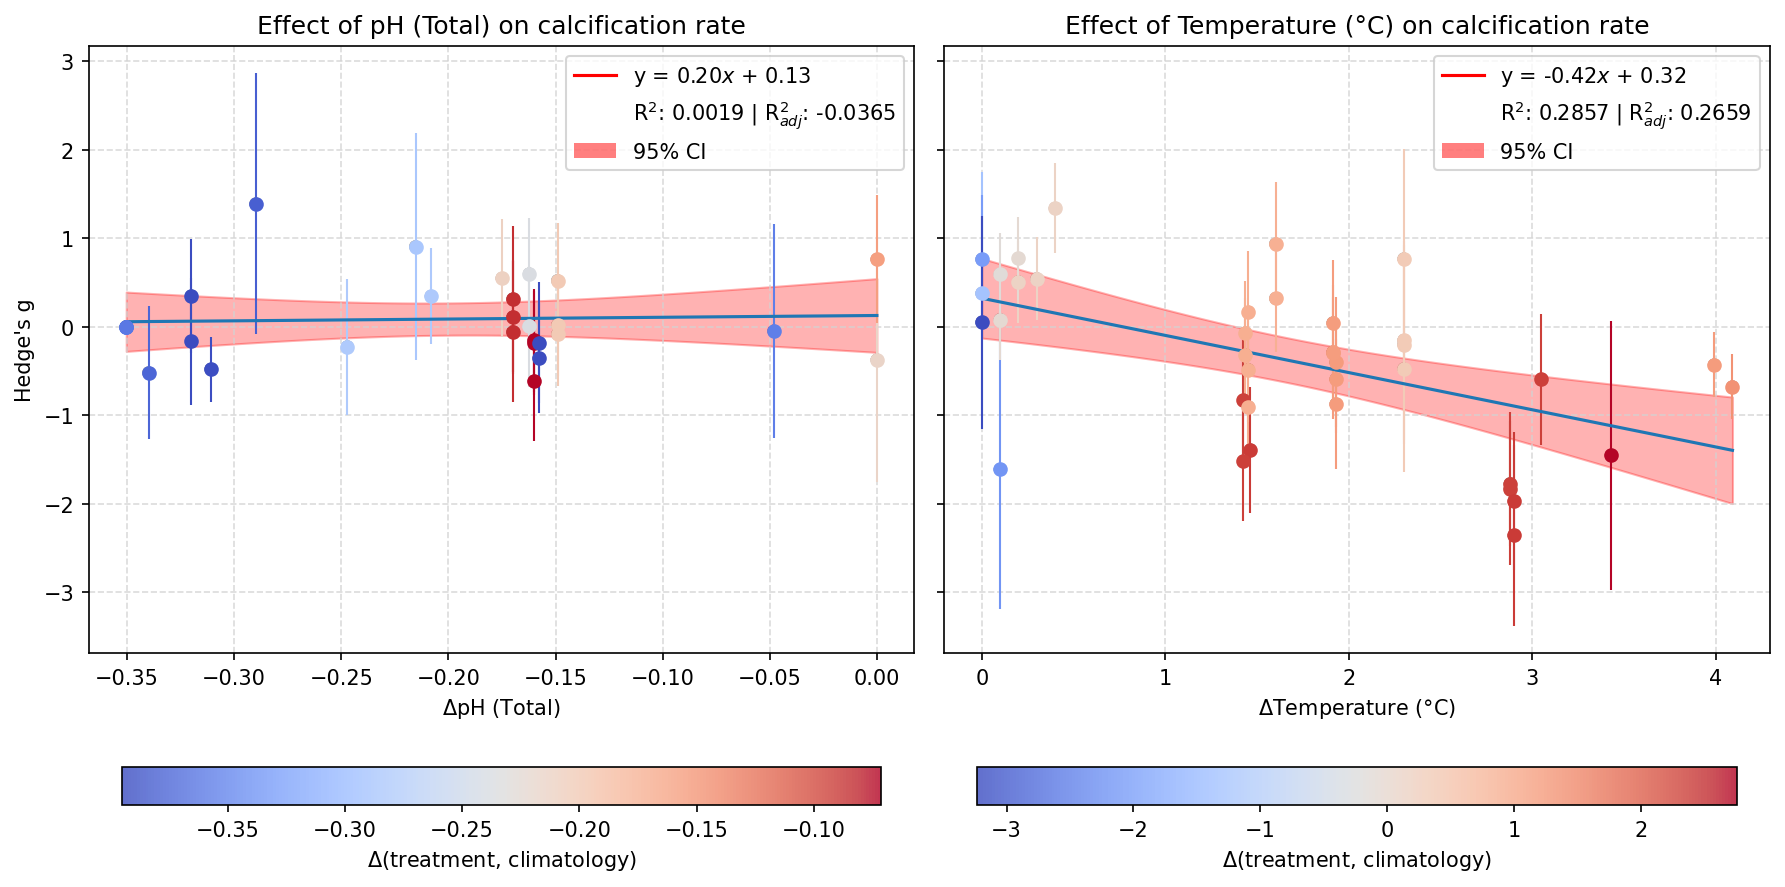

In [ ]:
sel_cols = ['species_types', 'treatment_group', 'phtot', 't_in', 'irr', 'calcification', 'calcification_sd', 'n']
study_df[sel_cols]

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])        # remove any rows containing nans
    


    # Scatter plot with color mapping
    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c='blue',
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend

    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()